##### Syed Ali Alim Rizvi

# Ridge Regression with SGD and BGD

In [1]:
library(reshape2)
library(ggplot2)
library(tidyr)

Warning message:
"package 'reshape2' was built under R version 3.5.1"Warning message:
"package 'ggplot2' was built under R version 3.5.1"
Attaching package: 'tidyr'

The following object is masked from 'package:reshape2':

    smiths



#### Functions

In [2]:

# reading the data and scale data for better behavior
read_data <- function(fname, sc) {
   data <- read.csv(file=fname,head=TRUE,sep=",")
   nr = dim(data)[1]
   nc = dim(data)[2]
   x = data[1:nr,1:(nc-1)]
   y = data[1:nr,nc]
   if (isTRUE(sc)) {
      x = scale(x)
      y = scale(y)
   }
   return (list("x" = x, "y" = y))
}

# auxiliary function to calculate labels based on the estimated coefficients
predict_func <- function(Phi, w){
    return(Phi%*%w)
} 

# auxiliary function to calculate the objective function for the training
train_obj_func <- function (Phi, w, label, lambda){
    # the L2 regulariser is already included in the objective function for training 
    return(mean((predict_func(Phi, w) - label)^2) + .5 * lambda * w %*% w)
}

# auxiliary function to compute the error of the model
get_errors <- function(train_data, test_data, W) {
   n_weights = dim(W)[1]
   errors = matrix(,nrow=n_weights, ncol=2)
   for (tau in 1:n_weights) {
      errors[tau,1] = train_obj_func(train_data$x, W[tau,],train_data$y, 0)
      errors[tau,2] = train_obj_func(test_data$x, W[tau,],test_data$y, 0)
   }
   return(errors)
}

##--- Stochastic Gradient Descent --------------------------------------------
sgd_train <- function(train_x, train_y, lambda, eta, epsilon, max_epoch) {

   train_len = dim(train_x)[1]
   tau_max = max_epoch * train_len

   W <- matrix(,nrow=tau_max, ncol=ncol(train_x)) 
   W[1,] <- runif(ncol(train_x))
  
   tau = 1 # counter 
   obj_func_val <-matrix(,nrow=tau_max, ncol=1) 
   obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)

   while (tau <= tau_max){

       # check termination criteria
       if (obj_func_val[tau,1]<=epsilon) {break}
 
       # shuffle data:
       train_index <- sample(1:train_len, train_len, replace = FALSE)
    
       # loop over each datapoint
       for (i in train_index) {
           # increment the counter
           tau <- tau + 1
           if (tau > tau_max) {break}

           # make the weight update
           y_pred <- predict_func(train_x[i,], W[tau-1,])
           W[tau,] <- sgd_update_weight(W[tau-1,], train_x[i,], train_y[i], y_pred, lambda, eta)

           # keep track of the objective funtion
           obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)
       }
   }
   # resulting values for the training objective function as well as the weights
   return(list('vals'=obj_func_val,'W'=W))
}

# updating the weight vector
sgd_update_weight <- function(W_prev, x, y_true, y_pred, lambda, eta) {
   # MODIFY THIS FUNCTION FOr L2 REG
   grad = - (y_true-y_pred) * x + lambda * W_prev
   return(W_prev - eta * grad)
}

##--- Batch Gradient Descent --------------------------------------------
bgd_train <- function(train_x, train_y, lambda, eta, epsilon, max_epoch) {

   train_len = dim(train_x)[1]

   W <- matrix(,nrow=(max_epoch+1), ncol=ncol(train_x))
   W[1,] <- runif(ncol(train_x))

   tau = 1 # counter 
   obj_func_val <-matrix(,nrow=(max_epoch+1), ncol=1)
   obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)

   trainin_size = dim(train_x)[1]
   for (tau in 1:max_epoch){

       # check termination criteria
       if (obj_func_val[tau,1]<=epsilon) {break}

       # make prediction over the training set
       y_pred = train_x %*% W[tau,]

       # update the weight you may decide to chose linea search or not (we are not using line search here)
       W[tau+1,] = bgd_update_weight(W[tau,], train_x, train_y, y_pred, lambda, eta)

       # keep track of the objective funtion
       obj_func_val[tau+1,1] = train_obj_func(train_x, W[tau+1,],train_y, lambda)
   } 
   # resulting values for the training objective function as well as the weights
   return(list('vals'=obj_func_val,'W'=W))
}

# updating the weight vector
bgd_update_weight <- function(W_prev, x, y_true, y_pred, lambda, eta) {
   # MODIFY THIS FUNCTION FOr L2 REG
   grad = -colMeans(matrix((y_true-y_pred),nrow=dim(x)[1],ncol=dim(x)[2]) * x)  + lambda * W_prev
   return (W_prev - eta * grad)
}

##------------------------------------------------------------------------


play_with_bgd <- function() {
   ## reading the data
   dtrain = read_data("RidgeReg_SGD_BGD_train.csv", TRUE)
   dtest = read_data("RidgeReg_SGD_BGD_test.csv", TRUE)

   ##### BGD Training
   max_epoch = 18
   epsilon = .001
   eta = .01
   lambda=0.1

   train_res = bgd_train(dtrain$x, dtrain$y, lambda, eta, epsilon, max_epoch)
   errors = get_errors(dtrain, dtest, train_res$W)
   plot(train_res$val, main="BGD", type="l", col="blue", xlab="iteration", ylab="training objective function")
   #plot(errors[1:19,1], type="l", col="blue",ylim=c(0,1), xlab="iteration", ylab="error")
   #lines(errors[1:19,2], type="l", lty=2, lwd=2, col="red")
    
   options(warn=-1)
    
    return (c(train_res, errors))
}


play_with_sgd <- function() {
   ## reading the data
   dtrain = read_data("RidgeReg_SGD_BGD_train.csv", TRUE)
   dtest = read_data("RidgeReg_SGD_BGD_test.csv", TRUE)
 
   ##### SGD Trainng
   max_epoch = 18
   epsilon = .001
   eta = .01
   lambda=0.1

   train_res = sgd_train(dtrain$x, dtrain$y, lambda, eta, epsilon, max_epoch)
   errors = get_errors(dtrain, dtest, train_res$W) 

   plot(train_res$val, main="SGD", type="l", col="blue", ylim=c(0,.1), xlab="iteration", ylab="training objective function")
   #plot(errors[1:16740,1], type="l", col="blue",ylim=c(0,1), xlab="iteration", ylab="error")
   #lines(errors[1:16740,2], type="l", lty=2, lwd=2, col="red")
    
    options(warn=-1)
    
    return (c(train_res, errors))
    
}



#### III.

In [3]:
t1c.train <- read.csv('RidgeReg_SGD_BGD_train.csv')
t1c.test <- read.csv('RidgeReg_SGD_BGD_test.csv')

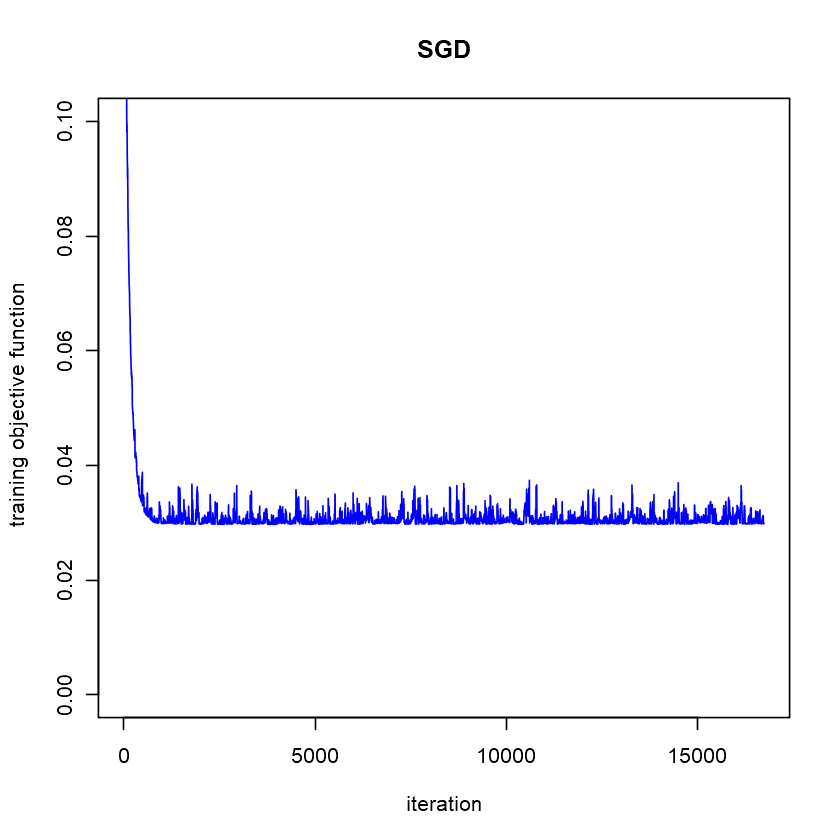

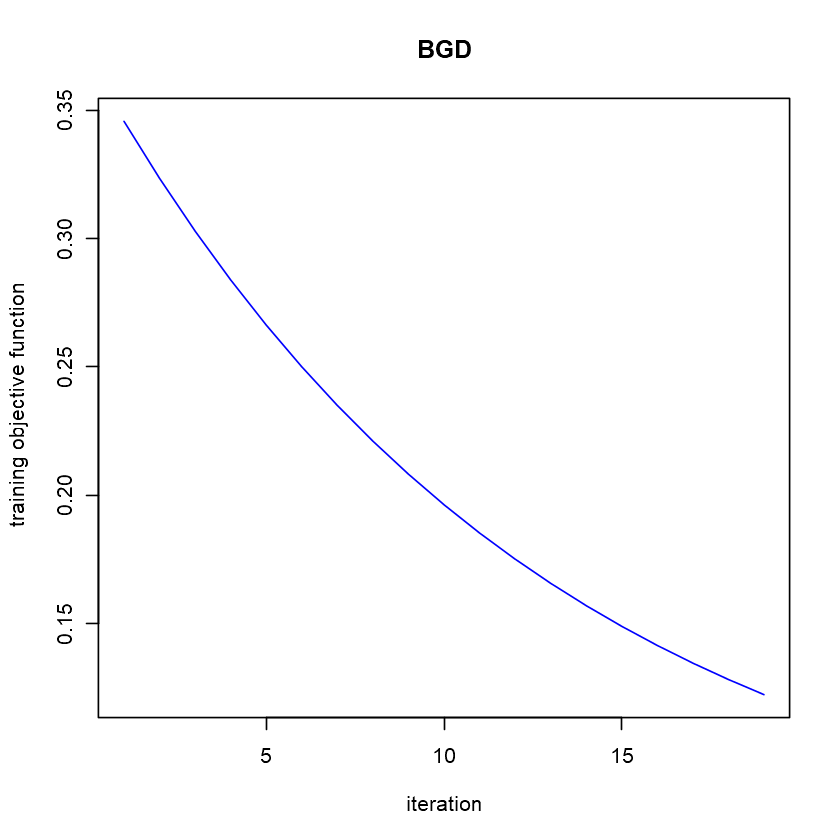

In [41]:
set.seed(222)

sgd_output <- play_with_sgd()
bgd_output <- play_with_bgd()
options(warn=-1)

In [42]:
#create empty dataframe for storage of the error values
my_err <- matrix(, nrow=dim(sgd_output[[1]]), ncol=3)
my_err <- setNames(data.frame(my_err), c("total.data.points","SGD", "BGD"))

In [43]:
#put in the values for the dataframe error and data points
my_err[,'total.data.points'] <- 1:(18*930)
my_err[,'SGD'] <- sgd_output[[1]]
my_err[1,'BGD'] <- bgd_output[[1]][1]

In [44]:
#put in bgd error in dataframe
for (i in 1:18) {
    my_err[i*dim(t1c.train)[1], 'BGD'] <- bgd_output[[1]][i+1] #first result is based on random 
}

In [45]:
# melt dataframe for easy visualization usage
my_err.m <- melt(my_err, id=c('total.data.points')) # reshape for visualization
names(my_err.m) <- c('total.data.points', 'type', 'error')

#drop rows with NA error (which exist because of BGD as it does not calculate error at every point)
my_err.m <- my_err.m %>% drop_na(error)

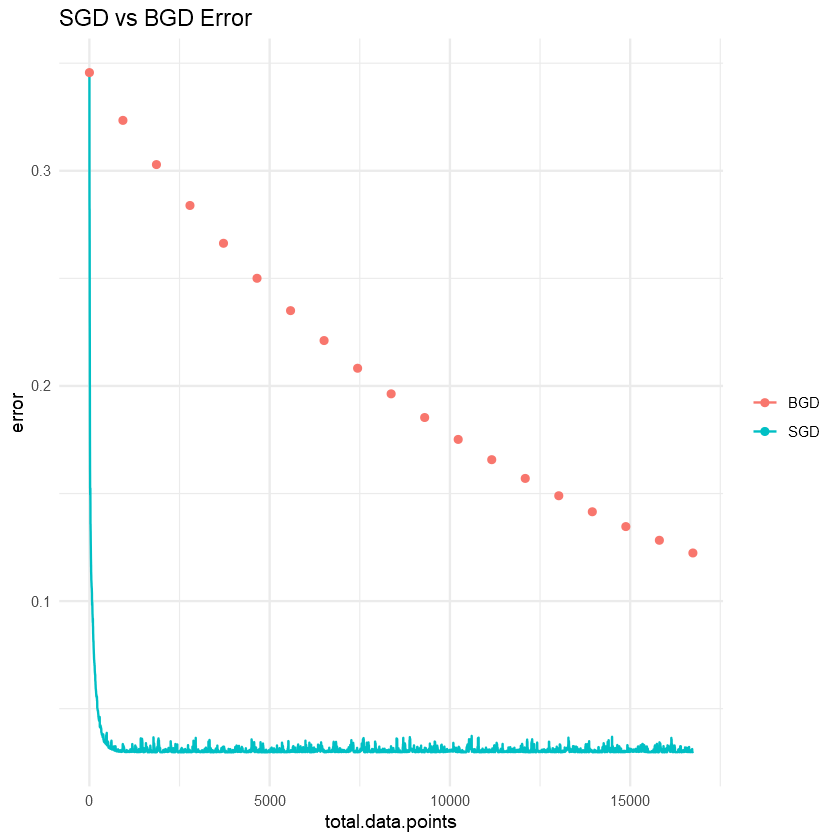

In [46]:
#create a scatter plot for the sgd and bgd errors
ggplot() + 
    geom_line(data=my_err.m[my_err.m$type=='SGD',], aes(x=total.data.points, y=error, color='SGD')) +  
    geom_point(data=my_err.m[my_err.m$type=='BGD',], aes(x=total.data.points, y=error, color='BGD')) +
    scale_color_discrete(guide = guide_legend(title = NULL)) + theme_minimal() +
    ggtitle("SGD vs BGD Error") 